# Image Classification using Logistic Regression in PyTorch

#### Part 3 of "PyTorch: Zero to GANs"

*This post is the third in a series of tutorials on building deep learning models with PyTorch, an open source neural networks library. Check out the full series:*

1. [PyTorch Basics: Tensors & Gradients](https://jovian.ml/aakashns/01-pytorch-basics)
2. [Linear Regression & Gradient Descent](https://jovian.ml/aakashns/02-linear-regression)
3. [Image Classfication using Logistic Regression](https://jovian.ml/aakashns/03-logistic-regression) 
4. [Training Deep Neural Networks on a GPU](https://jovian.ml/aakashns/04-feedforward-nn)
5. [Image Classification using Convolutional Neural Networks](https://jovian.ml/aakashns/05-cifar10-cnn)
6. [Data Augmentation, Regularization and ResNets](https://jovian.ml/aakashns/05b-cifar10-resnet)
7. [Generating Images using Generative Adverserial Networks](https://jovian.ml/aakashns/06-mnist-gan)


In this tutorial, we'll use our existing knowledge of PyTorch and linear regression to solve a very different kind of problem: *image classification*. We'll use the famous [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9), along with labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

## System setup

This tutorial takes a code-first approach towards learning PyTorch, and you should try to follow along by running and experimenting with the code yourself. The easiest way to start executing this notebook is to click the **"Run"** button at the top of this page, and select **"Run on Kaggle"**. This will run the notebook on Kaggle, a free online service for running Jupyter notebooks (you might need to create an account).

### Running on your computer locally
*(Skip this if you're running on Kaggle)* To run this notebook locally, clone this notebook, install the required dependencies using [conda](https://conda.io/en/latest/), and start Jupyter by running the following commands on the terminal / Conda prompt:

```bash
pip install jovian --upgrade                      # Install the jovian library 
jovian clone aakashns/03-logistic-regression      # Download notebook & dependencies
cd 03-logistic-regression                         # Enter the created directory 
conda create -n 03-logistic-regression python=3.8 # Create an environment
conda activate 03-logistic-regression             # Activate virtual env
jupyter notebook                                  # Start Jupyter
```

You can find the `notebook_id` by cliking the *Clone* button at the top of this page on Jovian. For a more detailed explanation of the above steps, check out the *System setup* section in the [first notebook](https://jovian.ml/aakashns/01-pytorch-basics).


## Exploring the Data

We begin by importing `torch` and `torchvision`. `torchvision` contains some utilities for working with image data. It also contains helper classes to automatically download and import popular datasets like MNIST.

In [59]:
#Uncomment and run the commands below if imports fail
#!conda install numpy pytorch torchvision cpuonly -c pytorch -y
#!pip install matplotlib --upgrade --quiet

In [60]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [61]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

When this statement is executed for the first time, it downloads the data to the `data/` directory next to the notebook and creates a PyTorch `Dataset`. On subsequent executions, the download is skipped as the data is already downloaded. Let's check the size of the dataset.

In [62]:
print(len(dataset))
print(dataset)

60000
Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train


The dataset has 60,000 images which can be used to train the model. There is also an additonal test set of 10,000 images which can be created by passing `train=False` to the `MNIST` class.

In [63]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Let's look at a sample element from the training dataset.

In [64]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F6202222470>, 5)

It's a pair, consisting of a 28x28 image and a label. The image is an object of the class `PIL.Image.Image`, which is a part of the Python imaging library [Pillow](https://pillow.readthedocs.io/en/stable/). We can view the image within Jupyter using [`matplotlib`](https://matplotlib.org/), the de-facto plotting and graphing library for data science in Python.

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

Along with importing `matplotlib`, a special statement `%matplotlib inline` is added to indicate to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with `%` are called IPython magic commands, and are used to configure the behavior of Jupyter itself. You can find a full list of magic commands here: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Let's look at a couple of images from the dataset.

Label: 5


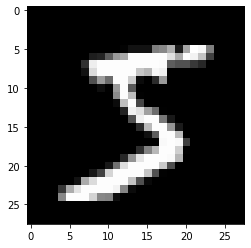

In [66]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


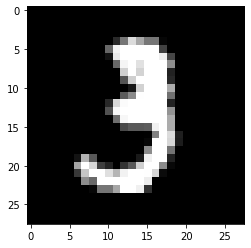

In [67]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

It's evident that these images are quite small in size, and recognizing the digits can sometimes be hard even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [68]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions which are applied to the images as they are loaded. `torchvision.transforms` contains many such predefined functions, and we'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [69]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [70]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a **1x28x28 tensor**. The second and third dimensions are the the pixel dimensions.The first dimension is used to keep track of the color channels. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are 3 channels: red, green and blue (RGB). Let's look at some sample values inside the tensor:  
*Note that printing out the whole tensor is a tad big, and we don't need all the values*

In [71]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))


tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white and the values in between different shades of grey. We can also plot the tensor as an image using `plt.imshow`.

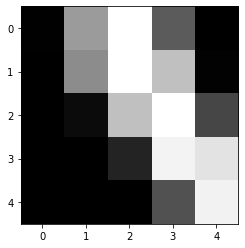

In [87]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

Note that we need to pass just the 28x28 matrix to `plt.imshow`, without a channel dimension. We also pass a color map (`cmap=gray`) to indicate that we want to see a grayscale image.

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the *best version of the model*.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In the MNIST dataset, there are 60,000 training images, and 10,000 test images. The test set is standardized so that different researchers can report the results of their models against the same set of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.  
ie- 50,000 images for training and 10,000 for validation

In [88]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's important to choose a random sample for creating a validation set, because training data is often ordered by the target labels i.e. images of 0s, followed by images of 1s, followed by images of 2s and so on. If we were to pick a 20% validation set simply by selecting the last 20% of the images, the validation set would only consist of images of 8s and 9s, whereas the training set would contain no images of 8s and 9s. This would make it impossible to train a good model using the training set, which also performs well on the validation set (and on real world data).

We can now created data loaders to help us load the data in batches. We'll use a batch size of 128.

In [89]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

**We set `shuffle=True` for the training dataloader, so that the batches generated in each epoch are different, and this randomization helps generalize & speed up the training process.** On the other hand, since the validation dataloader is used only for evaluating the model, there is no need to shuffle the images. 


Before we move forward, let's save our progress by uploading our notebook to [Jovian.ml](https://www.jovian.ml)

In [83]:
!pip install jovian --upgrade --quiet

In [84]:
import jovian

In [91]:
!jovian commit 03-logistic-regression.ipynb
#jovian.commit(project='03-logistic-regression', environment=None)

[jovian] No notebook found in path: 03-logistic-regression.ipynb


`jovian.commit` uploads the notebook to your [Jovian.ml](https://jovian.ml) account and creates a sharable link for the notebook. You can use this link to share your work and let anyone reproduce it easily with the jovian clone command. Jovian also includes a powerful commenting interface, so you (and others) can discuss & comment on specific parts of your notebook.

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model i.e. there are weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* Just as we did with linear regression, we can use `nn.Linear` to create the model instead of defining and initializing the matrices manually.

* Since `nn.Linear` expects the each training example to be a vector, each `1x28x28` image tensor needs to be flattened out into a vector of size 784 (`28*28`), before being passed into the model. 

* The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label (i.e. 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [93]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

Of course, this model is a lot larger than our previous model, in terms of the number of parameters. Let's take a look at the weights and biases.

In [94]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0047,  0.0191, -0.0245,  ...,  0.0020,  0.0125,  0.0173],
        [ 0.0019,  0.0339,  0.0308,  ..., -0.0099, -0.0028,  0.0219],
        [-0.0120,  0.0267, -0.0323,  ...,  0.0270,  0.0194,  0.0129],
        ...,
        [ 0.0289, -0.0214,  0.0338,  ...,  0.0259, -0.0116, -0.0314],
        [-0.0251,  0.0234,  0.0034,  ..., -0.0324,  0.0182,  0.0174],
        [ 0.0268, -0.0342, -0.0088,  ..., -0.0153, -0.0141,  0.0055]],
       requires_grad=True)

In [95]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0008,  0.0323, -0.0132,  0.0348, -0.0096, -0.0322,  0.0207, -0.0266,
         0.0356, -0.0021], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset, and pass them into our model.

In [96]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    break

tensor([1, 6, 6, 6, 7, 4, 1, 4, 3, 1, 4, 5, 1, 7, 9, 1, 0, 8, 8, 6, 1, 6, 0, 8,
        2, 2, 6, 7, 6, 6, 2, 7, 2, 6, 1, 3, 0, 3, 3, 0, 6, 4, 9, 1, 9, 3, 7, 9,
        4, 6, 0, 3, 6, 0, 9, 4, 1, 1, 7, 6, 9, 7, 9, 5, 6, 4, 9, 5, 9, 2, 8, 2,
        6, 9, 3, 7, 4, 8, 8, 1, 7, 6, 8, 4, 2, 6, 2, 4, 1, 7, 0, 5, 1, 4, 1, 2,
        8, 9, 5, 3, 2, 6, 5, 6, 0, 0, 4, 3, 5, 9, 9, 2, 9, 9, 0, 8, 7, 5, 8, 4,
        4, 3, 6, 7, 7, 9, 1, 1])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

This leads to an error, because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784 i.e. we need to flatten them out. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector, without really chaging the underlying data.

To include this additional functionality within our model, we need to define a custom model, by extending the `nn.Module` class from PyTorch.

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten out the input tensor, and then pass it into `self.linear`.

`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions, where the length along the 2nd dimension is 28\*28 (i.e. 784). One argument to `.reshape` can be set to `-1` (in this case the first dimension), to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method which returns a list containing the weights and bias, and can be used by a PyTorch optimizer.

In [ ]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

Our new custom model can be used in the exact same way as before. Let's see if it works.

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities, but for that the elements of each output row must lie between 0 to 1 and add up to 1, which is clearly not the case here. 

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

First we replace each element `yi` in an output row by `e^yi`, which makes all the elements positive, and then we divide each element by the sum of all elements to ensure that they add up to 1. 

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch, because it works well with multidimensional tensors (a list of output rows in our case).

In [ ]:
import torch.nn.functional as F

The softmax function is included in the `torch.nn.functional` package, and requires us to specify a dimension along which the softmax must be applied.

In [ ]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. This is done using `torch.max`, which returns the largest element and the index of the largest element along a particular dimension of a tensor.

In [ ]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [ ]:
labels

Clearly, the predicted and the actual labels are completely different. Obviously, that's because we have started with randomly initialized weights and biases. We need to train the model i.e. adjust the weights using gradient descent to make better predictions.

## Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the **accuracy** of the predictions. 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The `==` performs an element-wise comparison of two tensors with the same shape, and returns a tensor of the same shape, containing 0s for unequal elements, and 1s for equal elements. Passing the result to `torch.sum` returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy. 

Note that we don't need to apply softmax to the outputs, since it doesn't change the relative order of the results. This is because `e^x` is an increasing function i.e. if `y1 > y2`, then `e^y1 > e^y2` and the same holds true after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model, on the first batch of data. Obviously, we expect it to be pretty bad.

In [ ]:
accuracy(outputs, labels)

While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

Due to these reasons, accuracy is a great **evaluation metric** for classification, but not a good loss function. A commonly used loss function for classification problems is the **cross entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function. 

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.

In [ ]:
loss_fn = F.cross_entropy

In [ ]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

Since the cross entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples, one way to interpret the resulting number e.g. `2.23` is look at `e^-2.23` which is around `0.1` as the predicted probability of the correct label, on average. *Lower the loss, better the model.*

## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. Let's impelment the problem-specific parts within our `MnistModel` class:

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Now we'll define an `evaluate` function, which will perform the validation phase, and a `fit` function which will peform the entire training process.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

The `fit` function records the validation loss and metric from each epoch and returns a history of the training process. This is useful for debuggin & visualizing the training process. Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

Configurations like batch size, learning rate etc. need to picked in advance while training machine learning models, and are called hyperparameters. Picking the right hyperparameters is critical for training an accurate model within a reasonable amount of time, and is an active area of research and experimentation. Feel free to try different learning rates and see how it affects the training process.

In [ ]:
result0 = evaluate(model, val_loader)
result0

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly). Also note that we are using the `.format` method with the message string to print only the first four digits after the decimal point.

We are now ready to train the model. Let's train for 5 epochs and look at the results.

In [ ]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 80% on the validation set. Let's see if we can improve that by training for a few more epochs.

In [ ]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

In [ ]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

In [ ]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. This is easier to see using a line graph.

In [ ]:
# Replace these values with your results
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. It's possible that the model's paramaters are "bouncing" around the optimal set of parameters that have the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that **the model just isn't powerful enough**. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a **linear function** of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc. 

This would be a good time to save our work. Along with the notebook, we can also record some metrics from our training.

In [ ]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])

In [ ]:
jovian.commit(project='03-logistic-regression', environment=None)

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Here's a sample image from the dataset.

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [ ]:
img.unsqueeze(0).shape

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Let's try it out with a few images.

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

We expect this to be similar to the accuracy/loss on the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [ ]:
model.state_dict()

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [ ]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

## Commit and upload the notebook

As a final step, we can save and commit our work using the jovian library. Along with the notebook, we can also attach the weights of our trained model, so that we can use it later.

In [ ]:
!uname -h
import jovian
#jovian.commit(project='03-logistic-regression', environment=None, outputs=['mnist-logistic.pth'])

## Summary and Further Reading

We've created a fairly sophisticated training and evaluation pipeline in this tutorial. Here's a list of the topics we've covered:

* Working with images in PyTorch (using the MNIST dataset)
* Splitting a dataset into training, validation and test sets
* Creating PyTorch models with custom logic by extending the `nn.Module` class
* Interpreting model ouputs as probabilities using softmax, and picking predicted labels
* Picking a good evaluation metric (accuracy) and loss function (cross entropy) for classification problems
* Setting up a training loop that also evaluates the model using the validation set
* Testing the model manually on randomly picked examples 
* Saving and loading model checkpoints to avoid retraining from scratch

There's a lot of scope to experiment here, and I encourage you to use the interactive nature of Jupyter to play around with the various parameters. Here are a few ideas:

* Try making the validation set smaller or larger, and see how it affects the model.
* Try changing the learning rate and see if you can achieve the same accuracy in fewer epochs.
* Try changing the batch size. What happens if you use too high a batch size, or too low?
* Modify the `fit` function to also track the overall loss and accuracy on the training set, and see how it compares with the validation loss/accuracy. Can you explain why it's lower/higher?
* Train with a small subset of the data, and see if you can reach a similar level of accuracy.
* Try building a model for a different dataset, such as the [CIFAR10 or CIFAR100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html).

Here are some references for further reading:
* For a more mathematical treatment, see the popular [Machine Learning](https://www.coursera.org/lecture/machine-learning/classification-wlPeP) course on Coursera. Most of the images used in this tutorial series have been taken from this course.
* The training loop defined in this notebook was inspired from [FastAI development notebooks](https://github.com/fastai/fastai_docs/blob/master/dev_nb/001a_nn_basics.ipynb) which contain a wealth of other useful stuff if you can read and understand the code.
* For a deep dive into softmax and cross entropy, see [this blog post on DeepNotes](https://deepnotes.io/softmax-crossentropy).


With this we complete our discussion of logistic regression, and we're ready to move on to the next topic: *feedforward neural networks*!